In [1]:
#Import libraries
import pytz
import numpy as np
import keras
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_ta as ta
import MetaTrader5 as mt5
from datetime import datetime, timedelta, time

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
scaler = MinMaxScaler(feature_range=(0, 1))
def create_dataset(dataset, N=120):
    X, Y = [], []
    for i in range(len(dataset) - N):
        X.append(dataset[i:(i + N)])
        Y.append(dataset[i + N, -1])
    return np.array(X), np.array(Y)
# Apply the new function
N = 120
timezone = pytz.timezone("America/Bogota")
now = datetime.now(tz=timezone)


c:\Users\Angel\anaconda3\envs\proyect4\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
c:\Users\Angel\anaconda3\envs\proyect4\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Num GPUs Available:  1


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 120, 30)           3840      
                                                                 
 dropout_7 (Dropout)         (None, 120, 30)           0         
                                                                 
 lstm_8 (LSTM)               (None, 120, 25)           5600      
                                                                 
 dropout_8 (Dropout)         (None, 120, 25)           0         
                                                                 
 lstm_9 (LSTM)               (None, 120, 10)           1440      
                                                                 
 dropout_9 (Dropout)         (None, 120, 10)           0         
                                                                 
 dense_2 (Dense)             (None, 120, 1)           

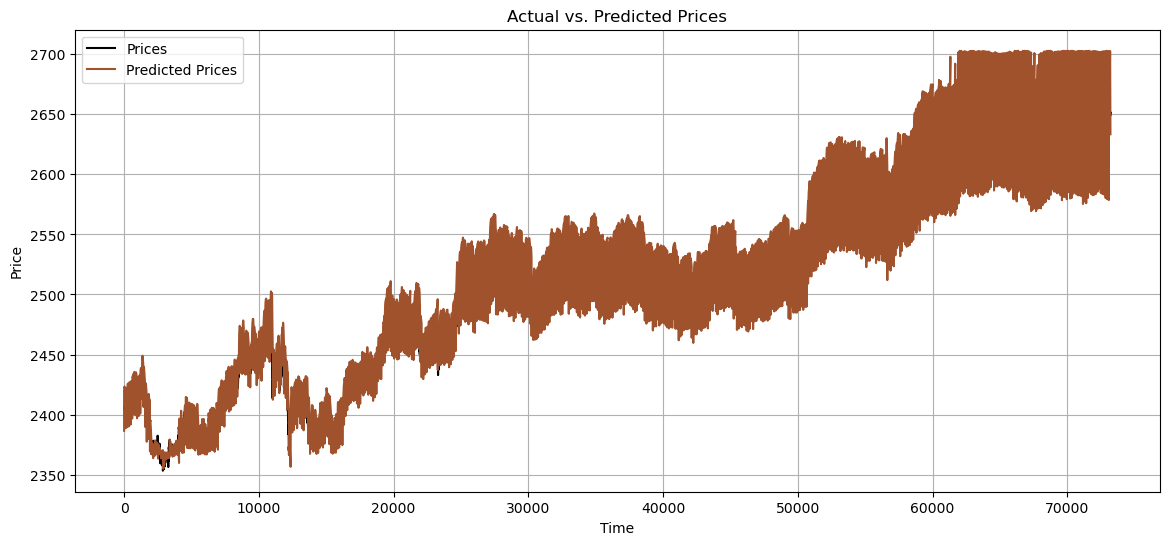

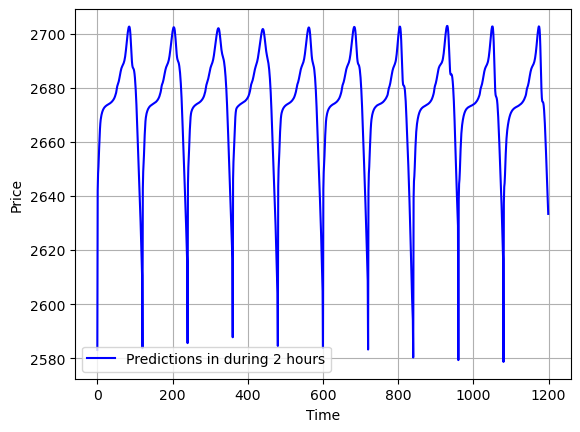

In [2]:
model = keras.models.load_model(r"C:\Users\Angel\OneDrive\Escritorio\Vs Code\.vscode\Cyniska0.2.keras")
model.summary()

if mt5.initialize():
    # Replace with your login credentials
    mt5.login(login=51863590, server="ICMarketsSC-Demo", password="1lfz&CJ7jyX2N8")
#CREATE A THE TEST DF
test = mt5.copy_rates_range('XAUUSD', mt5.TIMEFRAME_M1, datetime(2024, 6, 1), now)
test = pd.DataFrame(test)
test_1 = test['close'].tail(73368)
test_scaled = scaler.fit_transform(np.array(test_1).reshape(-1, 1))
_, X_test = create_dataset(test_scaled, N)
_, y_test = create_dataset(test_scaled, N)
#RESHAPE FOR PREDICTIONS
elements_two = X_test.size
divisible_two = (elements_two // 120) * 120
X_predict_shape = X_test[:divisible_two]
X_test = X_predict_shape.reshape(-1, 120, 1)

elements_one = y_test.size
divisible_one = (elements_one // 120) * 120
y_predict_shape = y_test[:divisible_one]
y_test = y_predict_shape.reshape(-1, 120, 1)

y_pred = model.predict(X_test)
# Inverse scaling
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_real = scaler.inverse_transform(y_test.reshape(-1, 1))
# y_pred_trimmed = y_pred[:len(y_real)] #Match the sizes
# y_real_trimmed = y_real[:len(y_pred)]
print("Test shapes for X and y respectivelly", X_test.shape, y_test.shape)
print("Test sizes for X and y respectivelly", X_test.size, y_test.size)
print(len(y_pred), y_pred.shape)
print(len(y_real), y_real.shape)
# Plot the results
now = datetime.now()
sixty_days = now + timedelta(days=60)
sixty_days = sixty_days.replace(microsecond=0)
date_range = pd.date_range(start=now.replace(microsecond=0), end=sixty_days, freq='1min')
date_range = date_range[date_range.dayofweek < 5]
time_df = pd.DataFrame(date_range)
rows = len(time_df)
print(f"Number of rows: {(rows)}")
plt.figure(figsize=(14, 6))
plt.plot(y_real, label='Prices', color='black')
plt.plot(y_pred, label='Predicted Prices', color='sienna')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices')
plt.grid(True)
plt.legend()
plt.show()
#PLot the predictions closer to see if the model is predicting good
plt.plot(y_pred[-1200:], color='blue', label='Predictions in during 2 hours')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()


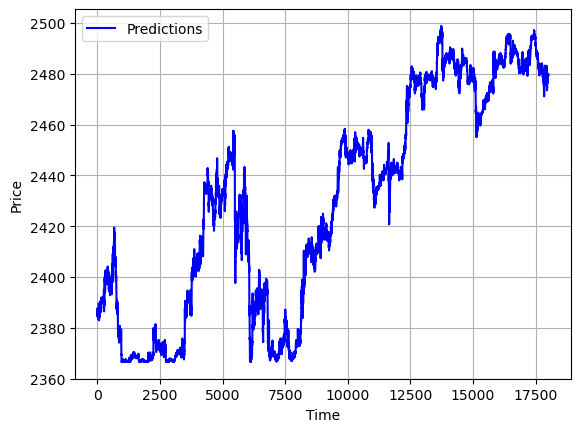

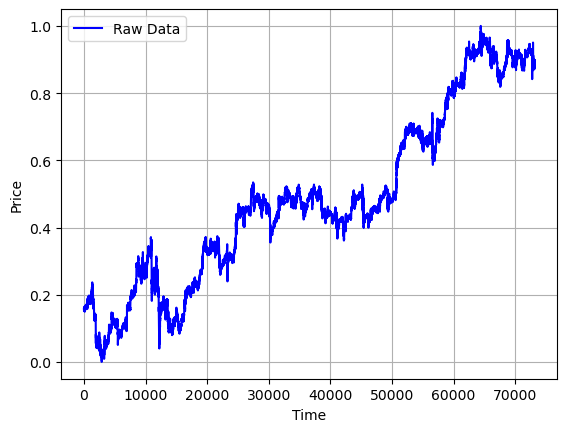

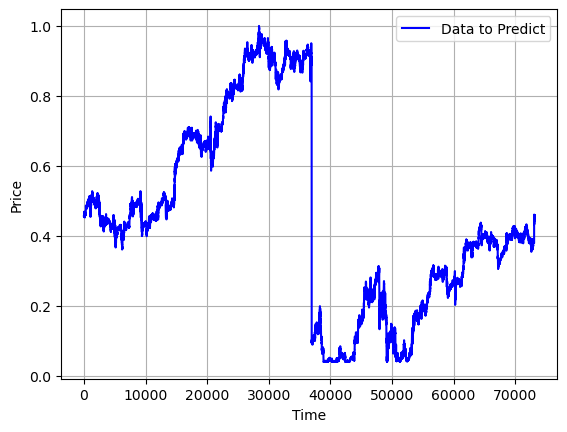

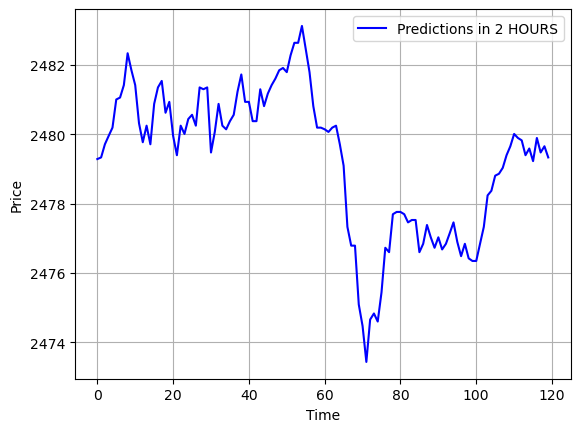

In [3]:
import math
batch_size = 60
M = 18000
R = 960  
timestamps = 2 
predictions = []
window_data = X_test[-R:] 
for i in range(M):
    prediction = model.predict(window_data.reshape(-1, N, 1), batch_size= batch_size, verbose=0)  # Reshape for LSTM
    predictions.append(prediction[0, 0])  
    window_data = np.roll(window_data, -timestamps)  # Shift data by one time step
    window_data[-timestamps] = prediction[0, 0]  # Update last value with prediction
    if len(prediction) > M:
        break
q = np.array(predictions).reshape(-1, 1)
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
# To show the real values   real = scaler.inverse_transform(np.array(window_data).reshape(-1, 1))
if np.isnan(predictions).sum() == 0:
    plt.plot(predictions, color='blue', label='Predictions')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("Predictions contain NaN values.")
if np.isnan(X_test[-R:].reshape(-1, 1)).sum() == 0:
    plt.plot(X_test[-R:].reshape(-1, 1), color='blue', label='Raw Data')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("Real Data contain NaN values.")
if np.isnan(window_data.reshape(-1, 1)).sum() == 0:
    plt.plot(window_data.reshape(-1, 1), color='blue', label='Data to Predict')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("Real Data contain NaN values.")
if np.isnan(predictions[-120:]).sum() == 0:
    plt.plot(predictions[-120:], color='blue', label='Predictions in 2 HOURS')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("Real Data contain NaN values.")

In [4]:
#SAVE THE DATAFRAMES
# stock_prices_df = pd.DataFrame(predictions)
# minutes_predicted = len(predictions)
# #Create a new full dataframe to be used in our trading bot.
# full_df = pd.concat([time_df, stock_prices_df], axis='columns')
# full_df = full_df.reset_index().drop_duplicates(subset='index', keep='last').set_index('index')
# full_df = full_df[:minutes_predicted]
# full_df.columns = ['Date', 'Price']
# full_df['Price'] = full_df['Price'].astype(float).round(8)

# #Save the dataframe
# full_df.to_csv("XAUUSD.csv", index=False)
# print(full_df.duplicated)